In [1]:
# Parameters
input_path = "data/outputs/structured_bner_selection1.bin"
selected_page = 14
sentence_in_focus = 2


--------------------------------


In [2]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

**Papermill variables**

In [3]:
#if not provided by papermill

if 'input_path' not in globals():
    input_path = "data/outputs/structured_bner_selection1.bin"

if 'selected_page' not in globals():
    selected_page = 208
    
if 'sentence_in_focus' not in globals():
    sentence_in_focus = 2

In [4]:
import os

#note that when ran with renku run from repo root, we're in a different work directory
current_dir = os.getcwd()

if str(current_dir).split("/")[-1] == "notebooks":
    input1_file = "../" + input_path
else:
    input1_file = input_path

**Welcome message**

In [5]:
import pyfiglet
from datetime import datetime


In [6]:
#see https://strftime.org/
when = datetime.now().strftime("Date: %B %d, %Y  Time: %H:%M:%S")
    
logo = pyfiglet.figlet_format("' Renku & Papermill '", font = "slant" )
    
#user-friendly welcome
aux_n = 100
blank_line = str("***").ljust(aux_n - 3) + "***"

print("*" * aux_n)
print(logo)
print(blank_line)
print(str("***  " + when).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("***  WILL RUN NOTEBOOK WITH:").ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** input_path:    " + input1_file).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** selected_page: " +str(selected_page)).ljust(aux_n - 3) + "***")
print(blank_line)
print(str("*** sentence in focus: " +str(sentence_in_focus)).ljust(aux_n - 3) + "***")
print(blank_line)
print("*" * aux_n)

****************************************************************************************************
  _    ____             __            ___        ____                                  _ ____   _ 
 ( )  / __ \___  ____  / /____  __   ( _ )      / __ \____ _____  ___  _________ ___  (_) / /  ( )
 |/  / /_/ / _ \/ __ \/ //_/ / / /  / __ \/|   / /_/ / __ `/ __ \/ _ \/ ___/ __ `__ \/ / / /   |/ 
    / _, _/  __/ / / / ,< / /_/ /  / /_/  <   / ____/ /_/ / /_/ /  __/ /  / / / / / / / / /       
   /_/ |_|\___/_/ /_/_/|_|\__,_/   \____/\/  /_/    \__,_/ .___/\___/_/  /_/ /_/ /_/_/_/_/        
                                                        /_/                                       

***                                                                                              ***
***  Date: July 17, 2021  Time: 12:17:56                                                         ***
***                                                                                              ***
*

----------------

In [7]:
import spacy
from spacy.tokens import Doc, Token, Span, SpanGroup, DocBin
from spacy import displacy

from spacy import displacy
import deplacy
import visualise_spacy_tree

import pandas as pd
import re

import pprint

In [8]:
pd.options.display.max_colwidth = 0 
pd.options.display.max_columns = None
pd.set_option('display.width', 1000)
pp = pprint.PrettyPrinter(width=150, compact=True)

In [9]:
#register token-level and span-level extensions in Spacy
try:
    #to deserialize docbin we need to set these again
    Token.set_extension("bner", default = []) 
    Token.set_extension("IS_BODY_ORGAN", default = 0)
    Token.set_extension("IS_MEDICATION", default = 0)
    Token.set_extension("IS_DISEASE", default = 0)
    
    Span.set_extension("IS_MEDICATION", default = 0)
    Span.set_extension("MEDICATION_DETAILS", default = {})
    
    Doc.set_extension("BOOK_PAGE", default = -1)
    
    #were assigned by medspacy context 
    Span.set_extension("is_family_history", default=0)
    Span.set_extension("is_history", default=0)
    Span.set_extension("never_family_history", default=0)
    Span.set_extension("never_history", default=0)
    
    #was set based on dep matcher, on medication ents that have relations to the diseases they are taken for
    Span.set_extension("PURPOSE", default="")
    
    #for visualization
    Token.set_extension('plot', default={})     

except:
    pass

In [10]:
nlp = spacy.load("en_core_web_lg", disable = ["ner"])

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


### Load Spacy DocBin

In [11]:
doc_bin = DocBin().from_disk(input1_file)

list_docs = list(doc_bin.get_docs(nlp.vocab))

**Select a doc for illustration**

In [12]:
doc = [doc for doc in list_docs if doc._.BOOK_PAGE == selected_page][0]

list_sentences = list(doc.sents)

df_sentences = pd.DataFrame([el.text for el in list_sentences], columns = ["sentence"])
df_sentences

,sentence
0,"An 89-year old woman presents to the emergency room with nausea and vomiting, cognitive changes, arrhythmias, xanthopsia, and reports seeing halos in both fields of vision."
1,"She has a past history of chronic obstructive pulmonary disease, chronic renal insufficiency, and heart failure."
2,"Her recently added medications include clarithromycin and digoxin (0.125 mg daily), for lobar pneumonia and heart failure respectively."
3,Her digoxin serum level is 1.5 ng/ml [0.5-2 ng/ml].
4,
5,What is the likely etiology of her current presentation?


-----------------------

### Visualize a dependency tree for one of the documents in the DocBin

In [13]:
 def display_tree(doc, nth_sentence = 0):
                
    #customize plot to highlight numbers, verbs and proper names
    sentence = list(doc.sents)[nth_sentence]
    print("SENTENCE:\n", sentence)
    print("-----------------------------------------------------------------------")
    for token in sentence:
        node_label = '{0}  [{1}] \n {2} / {3} \n {4}'.format(token.text, token.i, 
                                                             token.pos_, token.dep_,
                                                             token.ent_type_)
        token._.plot['label'] = node_label

        if token.ent_iob_ != "O":
            token._.plot["color"] = "red"
        else:
            if token.pos_ in ["PUNCT", "DET", "ADP", "NOUN"]:
                token._.plot["color"] = "lightgray" 
            elif token.pos_ in ["VERB", "AUX"]:
                token._.plot["color"] = "blue"
            else:
                token._.plot["color"] = "black" 

    png_tree = visualise_spacy_tree.create_png(sentence)
    display(Image(png_tree))

SENTENCE:
 An 89-year old woman presents to the emergency room with nausea and vomiting, cognitive changes,  arrhythmias, xanthopsia, and reports seeing halos in both fields of vision.
-----------------------------------------------------------------------


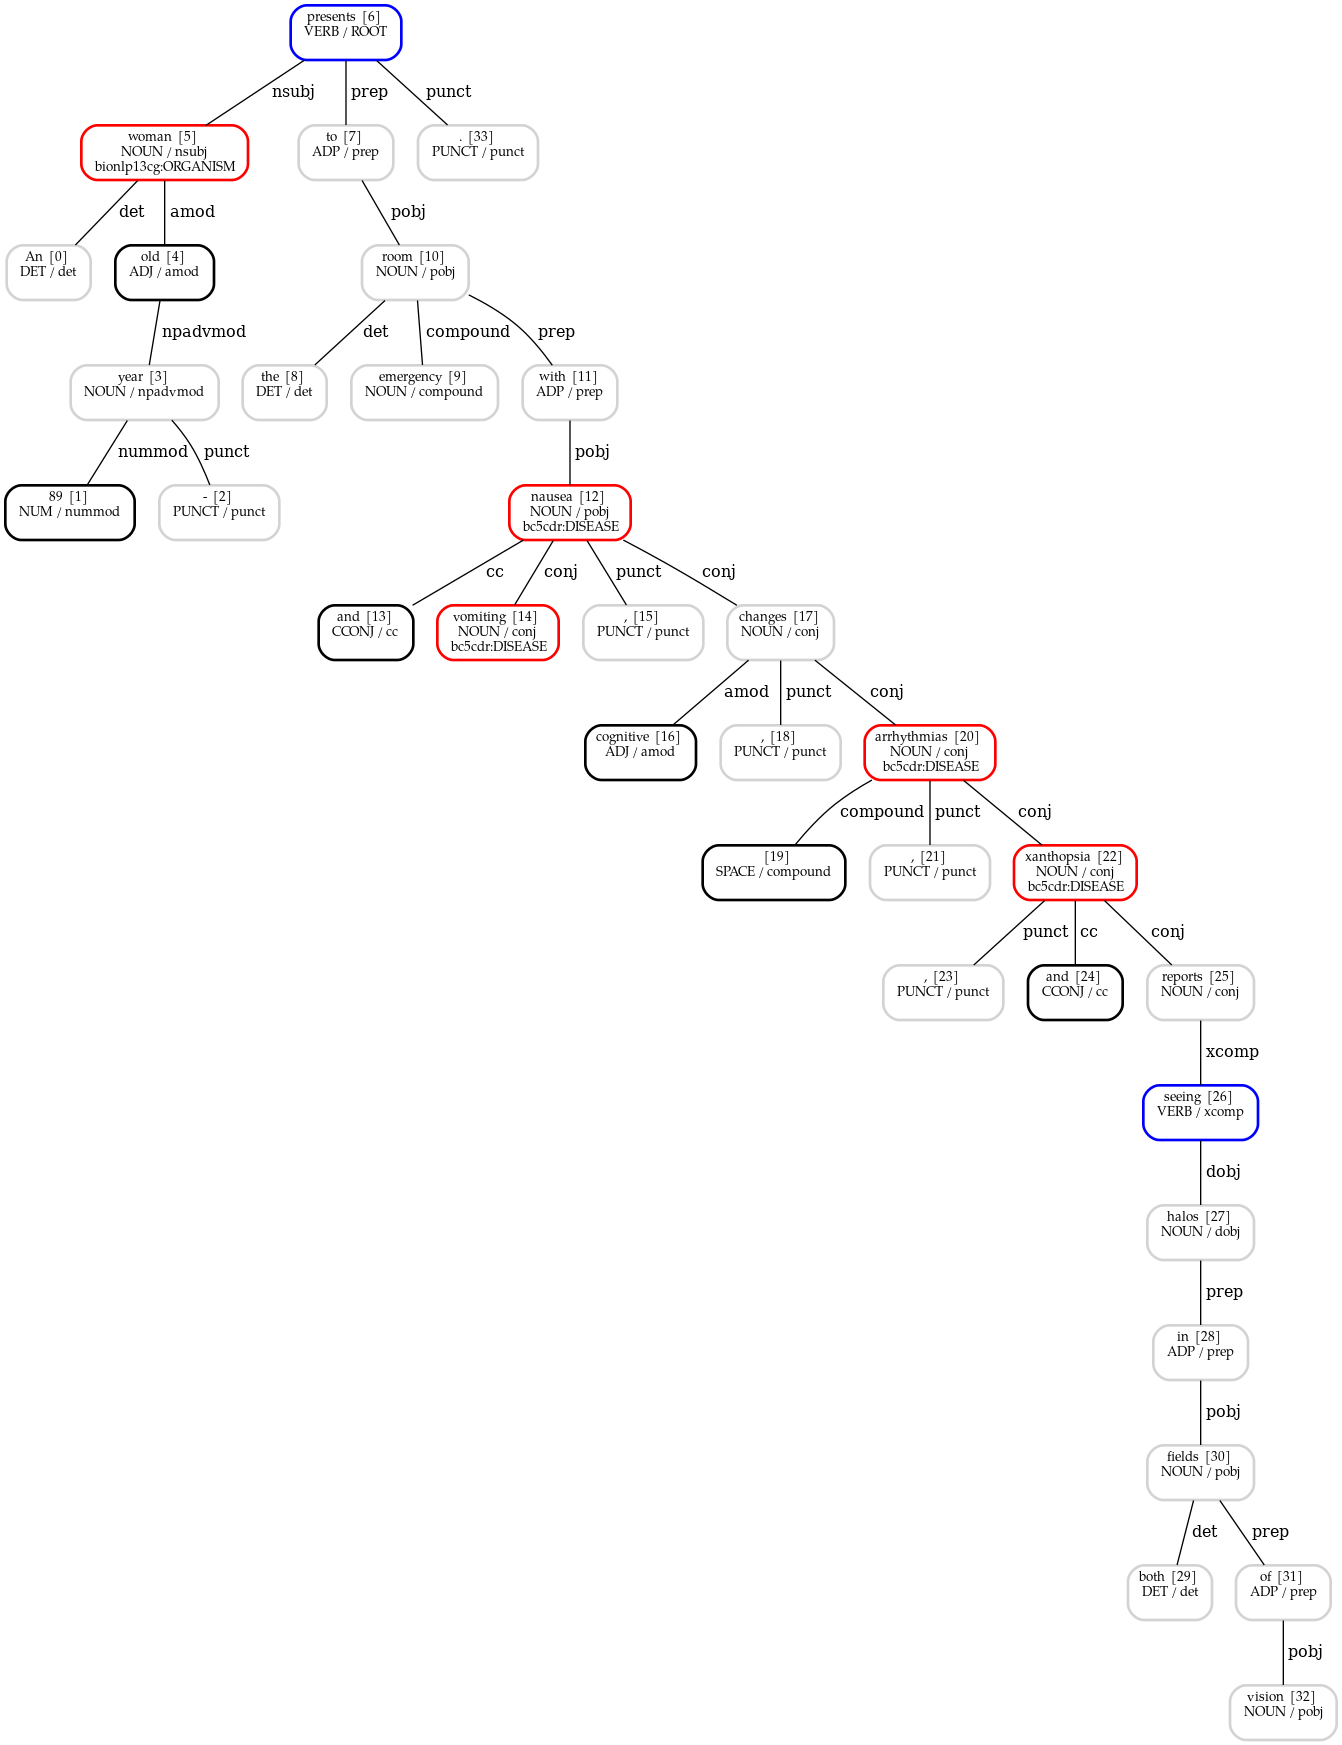

In [14]:
display_tree(doc, nth_sentence = 0)

SENTENCE:
 Her recently added medications  include clarithromycin and digoxin (0.125 mg daily), for lobar pneumonia and heart failure respectively.
-----------------------------------------------------------------------


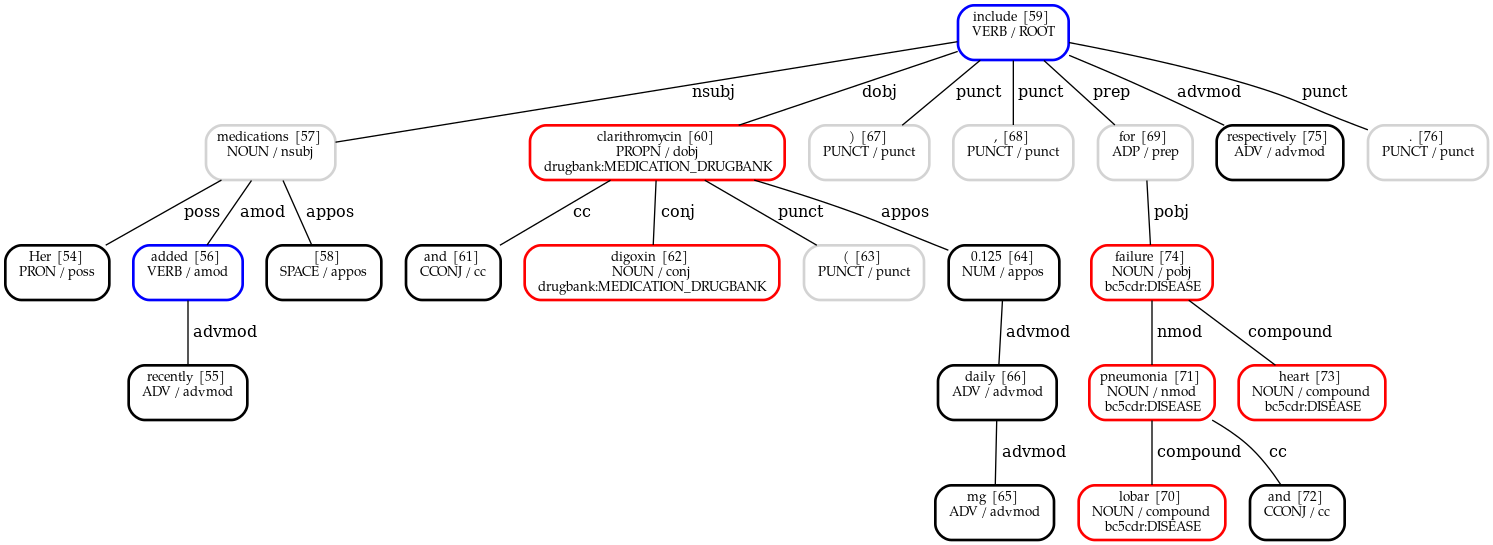

In [15]:
display_tree(doc, nth_sentence = sentence_in_focus)

**Alternative view:**

In [16]:
deplacy.render(list_sentences[sentence_in_focus],
               BoxDrawingWidth=1,EnableCR=False,WordRight=False,CatenaAnalysis=True)

Her            PRON  <════╗                 poss
recently       ADV   <╗   ║                 advmod
added          VERB  ═╝<╗ ║                 amod
medications    NOUN  ═╗═╝═╝<════╗           nsubj
               SPACE <╝         ║           appos
include        VERB  ═════════╗═╝═╗═╗═╗═╗═╗ ROOT
clarithromycin PROPN ═╗═╗═╗═╗<╝   ║ ║ ║ ║ ║ dobj
and            CCONJ <╝ ║ ║ ║     ║ ║ ║ ║ ║ cc
digoxin        NOUN  <══╝ ║ ║     ║ ║ ║ ║ ║ conj
(              PUNCT <════╝ ║     ║ ║ ║ ║ ║ punct
0.125          NUM   ═══╗<══╝     ║ ║ ║ ║ ║ appos
mg             ADV   <╗ ║         ║ ║ ║ ║ ║ advmod
daily          ADV   ═╝<╝         ║ ║ ║ ║ ║ advmod
)              PUNCT <════════════╝ ║ ║ ║ ║ punct
,              PUNCT <══════════════╝ ║ ║ ║ punct
for            ADP   ═══════╗<════════╝ ║ ║ prep
lobar          NOUN  <╗     ║           ║ ║ compound
pneumonia      NOUN  ═╝═╗<╗ ║           ║ ║ nmod
and            CCONJ <══╝ ║ ║           ║ ║ cc
heart          NOUN  <╗   ║ ║           ║ ║ compound
fail

---------------------

### Token level data

In [17]:
def inspect_tokens(doc, nth_sentence = 0):
    """prepare a dataframe with info about the tokens of the nth sentence of doc"""
    
    sentence = list(doc.sents)[nth_sentence]
    list_info_tokens = [{"token" : tok.text,
                         "parent_ent" : tok.ent_type_,
                         "IS_BODY_ORGAN" : tok._.IS_BODY_ORGAN ,
                         "IS_DISEASE" : tok._.IS_DISEASE,
                         "IS_MEDICATION" : tok._.IS_MEDICATION,
                         "list_ents" : tok._.bner,
                         "pos" : tok.pos_,
                         "dep" : tok.dep_,
                         "morph" :tok.morph,
                         "head" : tok.head
                        
                        } 
                        for tok in sentence]
    df_tokens = pd.DataFrame(list_info_tokens)
    
    return df_tokens

In [18]:
inspect_tokens(doc, nth_sentence = sentence_in_focus)

,token,parent_ent,IS_BODY_ORGAN,IS_DISEASE,IS_MEDICATION,list_ents,pos,dep,morph,head
0,Her,,0,0,0,(),PRON,poss,"(Gender=Fem, Number=Sing, Person=3, Poss=Yes, PronType=Prs)",medications
1,recently,,0,0,0,(),ADV,advmod,(),added
2,added,,0,0,0,(),VERB,amod,"(Aspect=Perf, Tense=Past, VerbForm=Part)",medications
3,medications,,0,0,0,(),NOUN,nsubj,(Number=Plur),include
4,,,0,0,0,(),SPACE,appos,(NumType=Card),medications
5,include,,0,0,0,(),VERB,ROOT,"(Tense=Pres, VerbForm=Fin)",include
6,clarithromycin,drugbank:MEDICATION_DRUGBANK,0,0,1,"((60, 61, drugbank:MEDICATION_DRUGBANK), (60, 61, bc5cdr:CHEMICAL), (60, 61, bionlp13cg:SIMPLE_CHEMICAL))",PROPN,dobj,"(NounType=Prop, Number=Sing)",include
7,and,,0,0,0,(),CCONJ,cc,(ConjType=Cmp),clarithromycin
8,digoxin,drugbank:MEDICATION_DRUGBANK,0,0,1,"((62, 63, bionlp13cg:SIMPLE_CHEMICAL), (62, 63, drugbank:MEDICATION_DRUGBANK), (62, 63, bc5cdr:CHEMICAL))",NOUN,conj,(Number=Sing),clarithromycin
9,(,,0,0,0,(),PUNCT,punct,"(PunctSide=Ini, PunctType=Brck)",clarithromycin


**Notes:** observe how a token (such as "omeprazole") has one main entity that it belongs to (of type "drugbank:MEDICATION_DRUGBANK") but has been recognized as biomedical entity by multiple models, so those annotations are stored in its custom extension tok._.bner

----------------

### Entities-level data

In [19]:
def inspect_entities(doc, nth_sentence = 0 ):
    """prepare a dataframe with info about the entities found in the nth sentence of doc"""
    sentence = list(doc.sents)[nth_sentence]
    
    list_info_entities = [{"entity" : ent.text,
                           "label" : ent.label_,
                           "IS_MEDICATION": ent._.IS_MEDICATION,
                           "PURPOSE" : ent._.PURPOSE,
                           "MEDICATION_DETAILS" : ent._.MEDICATION_DETAILS,
                           "family_past" : ent._.is_family_history,
                           "history" : ent._.is_history,
                           "not_family_past" : ent._.never_family_history,
                           "not_history" : ent._.never_history,                           
                           "start_char" : ent.start_char,
                           "end_char" : ent.end_char,
                           "start_tok" : ent.start,
                           "end_tok" : ent.end ,
                        
                        } 
                        for ent in sentence.ents]
    df_entities = pd.DataFrame(list_info_entities)
    
    return df_entities
        

In [20]:
inspect_entities(doc, nth_sentence = sentence_in_focus)

,entity,label,IS_MEDICATION,PURPOSE,MEDICATION_DETAILS,family_past,history,not_family_past,not_history,start_char,end_char,start_tok,end_tok
0,clarithromycin,drugbank:MEDICATION_DRUGBANK,1,heart failure,"{'drugbank_id': 'DB01211', 'rxnorm_link': ('C0055856', 'Clarithromycin', (), ('T109', 'T195'), 'A semisynthetic macrolide antibiotic derived from ERYTHROMYCIN that is active against a variety of microorganisms. It can inhibit PROTEIN SYNTHESIS in BACTERIA by reversibly binding to the 50S ribosomal subunits. This inhibits the translocation of aminoacyl transfer-RNA and prevents peptide chain elongation.')}",0,0,0,0,328,342,60,61
1,digoxin,drugbank:MEDICATION_DRUGBANK,1,lobar pneumonia,"{'drugbank_id': 'DB00390', 'rxnorm_link': ('C0012265', 'Digoxin', (), ('T109', 'T121'), 'A cardiotonic glycoside obtained mainly from Digitalis lanata; it consists of three sugars and the aglycone DIGOXIGENIN. Digoxin has positive inotropic and negative chronotropic activity. It is used to control ventricular rate in ATRIAL FIBRILLATION and in the management of congestive heart failure with atrial fibrillation. Its use in congestive heart failure and sinus rhythm is less certain. The margin between toxic and therapeutic doses is small. (From Martindale, The Extra Pharmacopoeia, 30th ed, p666)')}",0,0,0,0,347,354,62,63
2,lobar pneumonia,bc5cdr:DISEASE,0,,{},0,0,0,0,377,392,70,72
3,heart failure,bc5cdr:DISEASE,0,,{},0,0,0,0,397,410,73,75


---------------------------------

In [21]:
def visualize_entities(doc, nth_sentence = 0):
    sentence = list(doc.sents)[nth_sentence]
    
    colors = {"drugbank:MEDICATION_DRUGBANK" : "#fce9a2", "bc5cdr:DISEASE":"#facdee"}
    html_ents = displacy.render(sentence, style='ent', 
                                options={"colors":colors}, 
                                page=True, jupyter=False, minify=True)
    return html_ents


In [22]:
html_ents = visualize_entities(doc, nth_sentence = sentence_in_focus)

display(HTML(html_ents))

**Inspecting the HTML produced, for better understanding we highlight HTML tags in the text**

In [23]:
html_ents

'<!DOCTYPE html><html lang="en"><head><title>displaCy</title></head><body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, \'Segoe UI\', Helvetica, Arial, sans-serif, \'Apple Color Emoji\', \'Segoe UI Emoji\', \'Segoe UI Symbol\'; padding: 4rem 2rem; direction: ltr"><figure style="margin-bottom: 6rem"><div class="entities" style="line-height: 2.5; direction: ltr">Her recently added medications  include <mark class="entity" style="background: #fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">clarithromycin<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">drugbank:MEDICATION_DRUGBANK</span></mark> and <mark class="entity" style="background: #fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">digoxin<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: midd

In [24]:
#utility for custom printing - from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [25]:
#we bold and color some of the html tags for better analysis of this produced html 

ss = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">"""

html_ents_postproc = ( html_ents
                      .replace("</mark>", color.BOLD + color.BLUE + "</mark>" + color.END)
                      .replace(ss, color.BOLD + color.PURPLE + ss + color.END)
                      .replace("</span>", color.BOLD + color.PURPLE + "</span>" + color.END)
                     )

#for styling the <mark> tags we need a REGEX, the matching group (in paranthesis) is later found as \g1
# test the regex at https://regexr.com/

rgx = re.compile(r'(<mark class="entity" [^>]*>)')
html_ents_postproc = rgx.sub(color.BOLD + color.BLUE + r'\1' + color.END, html_ents_postproc)


In [26]:
html_ents_postproc2 = html_ents_postproc.replace(">", ">#").replace("<","#<")
print("\n".join(html_ents_postproc2.split("#")))


<!DOCTYPE html>

<html lang="en">

<head>

<title>
displaCy
</title>

</head>

<body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">

<figure style="margin-bottom: 6rem">

<div class="entities" style="line-height: 2.5; direction: ltr">
Her recently added medications  include 
<mark class="entity" style="background: 
fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
clarithromycin
<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">
drugbank:MEDICATION_DRUGBANK
</span>

</mark>
 and 
<mark class="entity" style="background: 
fce9a2; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
digoxin
<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; 